In [1]:
import pandas as pd

In [85]:
dataset = pd.read_csv("google.csv", index_col=[0])

In [3]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-24,106.570000,107.589996,106.309998,107.389999,99.459969,2032600
1,2015-11-25,107.510002,107.660004,107.250000,107.470001,99.534058,1820300
2,2015-11-27,107.589996,107.760002,107.220001,107.629997,99.682251,552400
3,2015-11-30,107.779999,107.849998,107.110001,107.169998,99.256210,3618100
4,2015-12-01,107.589996,108.209999,107.370003,108.180000,100.191628,2443600


In [86]:
dataset.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
99,"May 10, 2019",1163.59,1172.60,1142.50,1164.27,1164.27,1314500.0
98,"May 13, 2019",1141.96,1147.94,1122.11,1132.03,1132.03,1860600.0
97,"May 14, 2019",1137.21,1140.42,1119.55,1120.44,1120.44,1836600.0
96,"May 15, 2019",1117.87,1171.33,1116.67,1164.21,1164.21,2289300.0
95,"May 16, 2019",1164.51,1188.16,1162.84,1178.98,1178.98,1531400.0


In [4]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [89]:
stk_path = "google.csv"
test_size = 0.2
cv_size = 0.2

N = 9

lstm_units = 50
dropout_prob = 1
optimizer = 'adam'
epochs = 1
batch_size = 1

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [90]:
seed(101)
set_random_seed(model_seed)

In [91]:
def get_mape(y_true, y_pred):
    # Mean Absolute Percentage Error
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [92]:
def get_x_y(data, N, offset):
    # Split data into x (features) and y (target)
    
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [93]:
def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i] - mu_list[i-offset]) / std_list[i-offset])
        y.append(data[i])
    
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

In [94]:
def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #Do Prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled* np.array(std_cv_list).reshape(-1, 1)) + np.array(mu_cv_list).reshape(-1, 1)
    
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

In [95]:
df = pd.read_csv(stk_path, sep=",", index_col=[0])

In [96]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
99,"May 10, 2019",1163.59,1172.60,1142.50,1164.27,1164.27,1314500.0
98,"May 13, 2019",1141.96,1147.94,1122.11,1132.03,1132.03,1860600.0
97,"May 14, 2019",1137.21,1140.42,1119.55,1120.44,1120.44,1836600.0
96,"May 15, 2019",1117.87,1171.33,1116.67,1164.21,1164.21,2289300.0
95,"May 16, 2019",1164.51,1188.16,1162.84,1178.98,1178.98,1531400.0


In [97]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

ValueError: time data May 10, 2019 doesn't match format specified

In [98]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
99,"May 10, 2019",1163.59,1172.60,1142.50,1164.27,1164.27,1314500.0
98,"May 13, 2019",1141.96,1147.94,1122.11,1132.03,1132.03,1860600.0
97,"May 14, 2019",1137.21,1140.42,1119.55,1120.44,1120.44,1836600.0
96,"May 15, 2019",1117.87,1171.33,1116.67,1164.21,1164.21,2289300.0
95,"May 16, 2019",1164.51,1188.16,1162.84,1178.98,1178.98,1531400.0


In [15]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [16]:
df.head()

,date,open,high,low,close,adj_close,volume
0,2015-11-24,106.570000,107.589996,106.309998,107.389999,99.459969,2032600
1,2015-11-25,107.510002,107.660004,107.250000,107.470001,99.534058,1820300
2,2015-11-27,107.589996,107.760002,107.220001,107.629997,99.682251,552400
3,2015-11-30,107.779999,107.849998,107.110001,107.169998,99.256210,3618100
4,2015-12-01,107.589996,108.209999,107.370003,108.180000,100.191628,2443600


In [17]:
# Get month of each sample
df['month'] = df['date'].dt.month

In [18]:
df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-24,106.570000,107.589996,106.309998,107.389999,99.459969,2032600,11
1,2015-11-25,107.510002,107.660004,107.250000,107.470001,99.534058,1820300,11
2,2015-11-27,107.589996,107.760002,107.220001,107.629997,99.682251,552400,11
3,2015-11-30,107.779999,107.849998,107.110001,107.169998,99.256210,3618100,11
4,2015-12-01,107.589996,108.209999,107.370003,108.180000,100.191628,2443600,12


In [19]:
# sort by datetime

df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-24,106.570000,107.589996,106.309998,107.389999,99.459969,2032600,11
1,2015-11-25,107.510002,107.660004,107.250000,107.470001,99.534058,1820300,11
2,2015-11-27,107.589996,107.760002,107.220001,107.629997,99.682251,552400,11
3,2015-11-30,107.779999,107.849998,107.110001,107.169998,99.256210,3618100,11
4,2015-12-01,107.589996,108.209999,107.370003,108.180000,100.191628,2443600,12


Text(0, 0.5, 'USD')

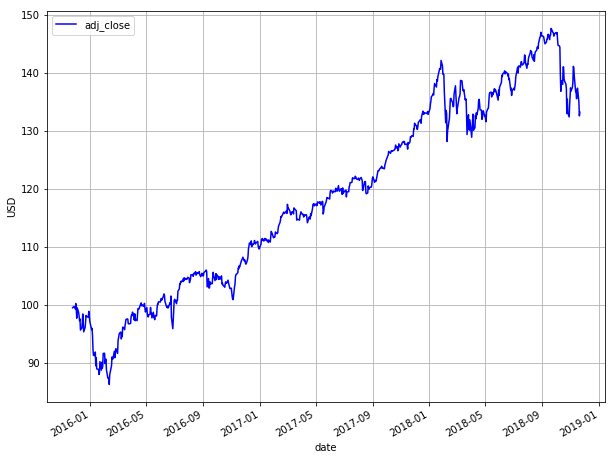

In [20]:
# Plot adjusted close over time

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel('date')
ax.set_ylabel("USD")

In [21]:
# Size of each dataset
num_cv = int(cv_size * len(df))
num_test = int(test_size * len(df))
num_train = len(df) - num_cv - num_test

In [24]:
num_cv, num_test, num_train

(151, 151, 453)

In [26]:
# Splitting into train, cv and test

train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

In [27]:
train.shape

(453, 2)

In [28]:
cv.shape

(151, 2)

In [29]:
train_cv.shape

(604, 2)

In [30]:
test.shape

(151, 2)

In [31]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak

scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))

In [34]:
train.head()

,date,adj_close
0,2015-11-24,99.459969
1,2015-11-25,99.534058
2,2015-11-27,99.682251
3,2015-11-30,99.256210
4,2015-12-01,100.191628


In [36]:
train_scaled

array([[-0.78263698],
       [-0.77487449],
       [-0.75934794],
       [-0.80398531],
       [-0.70597926],
       [-0.81563098],
       [-0.9708865 ],
       [-0.78263698],
       [-0.86414682],
       [-0.9262507 ],
       [-1.01455336],
       [-0.98447224],
       [-1.18533626],
       [-1.14943262],
       [-1.04172254],
       [-0.89422951],
       [-1.04560498],
       [-1.21832785],
       [-1.13898827],
       [-1.04823079],
       [-0.92136432],
       [-0.93405164],
       [-0.95649736],
       [-0.84719735],
       [-0.92526909],
       [-1.02480985],
       [-1.17704697],
       [-1.15460282],
       [-1.28927338],
       [-1.53226955],
       [-1.64254635],
       [-1.64839915],
       [-1.58301474],
       [-1.83089174],
       [-1.68743706],
       [-1.88749129],
       [-1.89725137],
       [-1.9889848 ],
       [-1.95287654],
       [-1.75574714],
       [-1.91091464],
       [-1.76941041],
       [-1.8767584 ],
       [-1.83967659],
       [-1.60741163],
       [-1

In [37]:
scaler.mean_

array([106.92984125])

In [38]:
scaler.var_

array([91.09732471])

In [41]:
# Split into x and y

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)

In [42]:
x_train_scaled.shape

(444, 9, 1)

In [43]:
y_train_scaled.shape

(444, 1)

In [44]:
# Scale the CV dataset

x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1, 1), N, num_train)

In [45]:
x_cv_scaled.shape

(151, 9, 1)

In [46]:
y_cv.shape

(151, 1)

In [50]:
# Here we scale the train_cv set, for the final model

scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1, 1))

In [51]:
train_cv_scaled_final.shape

(604, 1)

In [52]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/1
 - 8s - loss: 0.0607


In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (151, 1)
RMSE = 2.173
MAPE = 1.145%


Text(0, 0.5, 'USD')

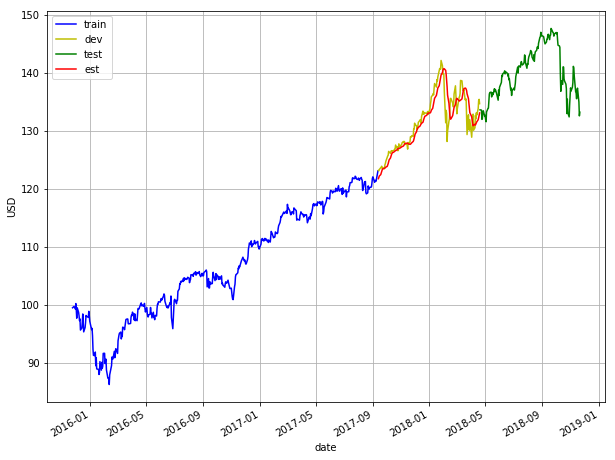

In [56]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [57]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, 3, 3)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), 3, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=128, \
                                        dropout_prob=1, \
                                        optimizer='nadam', \
                                        epochs=50, \
                                        batch_size=8)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.153
MAPE on test set = 0.586%


Text(0, 0.5, 'USD')

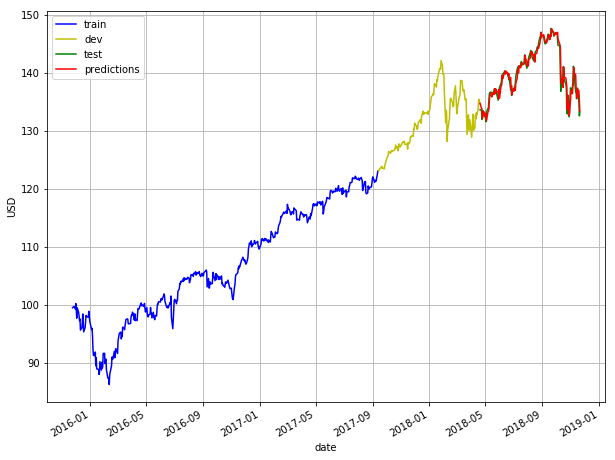

In [58]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

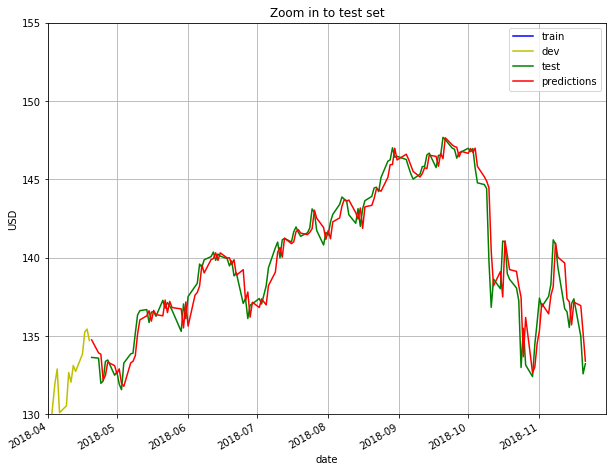

In [59]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

(130, 155)

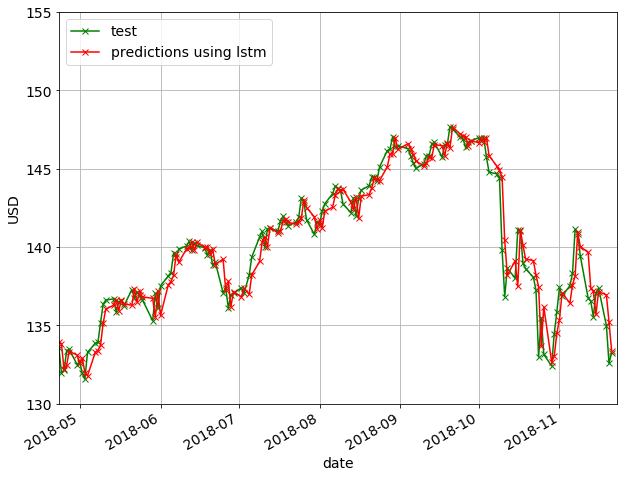

In [60]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])